## 第十週：主題模型（中文）
Last modified: 蔡睿澤（2024/04/23） <br>

本週課程為 **主題模型** ，學習如何將文本進行主題模型分析。<br>
文件主題模型採用非監督式學習的方式，不事先人為做標籤與註解，訓練的資料是從資料文本得來，讓我們可以規模化給予大量文本，而訓練出主題模型，其中最為知名為LDA模型，也是本次課程主要的教學目標，本 jupyter notebook 是以中文文本為示範。<br>
<br>
這次課程分為7個部分：
1. 介紹使用到的套件 
2. 將資料進行前處理 
3. lexicon-based 的主題模型
4. LDA 主題模型 
5. 視覺化主題模型 
6. GuidedLDA
7. 主題模型的應用

## 1. 套件說明
本次實作過程中使用到的相關套件，在課堂中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
+ gensim: 主題模型函式庫
+ pyLDAvis: 互動式LDA視覺化套件

In [1]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
# 設定中文字體
plt.rcParams['font.sans-serif']=['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus']=False

## 2. 資料前處理

In [4]:
udn = pd.read_csv("raw_data/ebc_2024_04.csv")  # 匯資料
udn.head(3)

,system_id,artCatagory,artTitle,dataSource,artUrl,artDate,artContent
0,1,娛樂,專訪／從月賺3千到60萬！台灣首位千萬YTR奇軒 親曝漲粉秘訣｜東森新聞,EBC,https://news.ebc.net.tw/news/article/412111,2024-04-16 10:11:00,「我曾經每個月只有賺3千元！」YouTuber奇軒（本名吳奇軒）從武打演員到月收入60萬，不...
1,2,娛樂,韓韶禧驚爆感情爭議「丟2代言」？ 品牌方說話了｜東森新聞,EBC,https://news.ebc.net.tw/news/article/412908,2024-04-01 07:59:00,南韓女星韓韶禧在被拍到與柳俊烈共同到夏威夷旅遊後，火速認愛。不過，男方前女友惠利的一句「真有...
2,3,娛樂,李天怡抓野生動物當臨演 非洲人都看不下去全說了｜東森新聞,EBC,https://news.ebc.net.tw/news/article/412918,2024-04-01 08:20:00,知名主播李天怡受三立老闆張榮華委託，替頑皮世界動物園赴非洲購買野生動物，卻浮報價格上億元，涉...


In [5]:
# 移除網址格式
# 只留下中文字
udn["artContent"] = udn["artContent"].str.replace("(http|https)://.*", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("(http|https)://.*", "", regex=True)
udn["artContent"] = udn["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn['content'] = udn['artContent']


udn = udn.loc[:,["content", "artUrl", "artCatagory", 'artDate']]  # 文章內容 文章連結
udn.head(3)

,content,artUrl,artCatagory,artDate
0,我曾經每個月只有賺千元奇軒本名吳奇軒從武打演員到月收入萬不靠著腥羶色炒話題更成為台灣首位千萬...,https://news.ebc.net.tw/news/article/412111,娛樂,2024-04-16 10:11:00
1,南韓女星韓韶禧在被拍到與柳俊烈共同到夏威夷旅遊後火速認愛不過男方前女友惠利的一句真有趣卻意外...,https://news.ebc.net.tw/news/article/412908,娛樂,2024-04-01 07:59:00
2,知名主播李天怡受三立老闆張榮華委託替頑皮世界動物園赴非洲購買野生動物卻浮報價格上億元涉背信罪...,https://news.ebc.net.tw/news/article/412918,娛樂,2024-04-01 08:20:00


In [6]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

udn["words"] = udn["content"].apply(getToken)
udn.head()

Building prefix dict from c:\Nicole\NSYU\社群媒體分析\Practice\Social-Media-Analysis\week10\dict\dict.txt.big ...
2024-05-06 15:03:28,733 : DEBUG : Building prefix dict from c:\Nicole\NSYU\社群媒體分析\Practice\Social-Media-Analysis\week10\dict\dict.txt.big ...
Loading model from cache C:\Users\giyak\AppData\Local\Temp\jieba.ue82dc224860194dd853ddcbe8365d890.cache
2024-05-06 15:03:28,735 : DEBUG : Loading model from cache C:\Users\giyak\AppData\Local\Temp\jieba.ue82dc224860194dd853ddcbe8365d890.cache
Loading model cost 0.843 seconds.
2024-05-06 15:03:29,577 : DEBUG : Loading model cost 0.843 seconds.
Prefix dict has been built successfully.
2024-05-06 15:03:29,579 : DEBUG : Prefix dict has been built successfully.


,content,artUrl,artCatagory,artDate,words
0,我曾經每個月只有賺千元奇軒本名吳奇軒從武打演員到月收入萬不靠著腥羶色炒話題更成為台灣首位千萬...,https://news.ebc.net.tw/news/article/412111,娛樂,2024-04-16 10:11:00,"[曾經, 每個, 千元, 奇軒, 本名, 吳奇軒, 武打, 演員, 收入, 不靠, 腥羶, ..."
1,南韓女星韓韶禧在被拍到與柳俊烈共同到夏威夷旅遊後火速認愛不過男方前女友惠利的一句真有趣卻意外...,https://news.ebc.net.tw/news/article/412908,娛樂,2024-04-01 07:59:00,"[韓女星, 韓韶禧, 柳俊烈, 共同, 夏威夷, 旅遊, 火速, 認愛, 男方, 前女友, ..."
2,知名主播李天怡受三立老闆張榮華委託替頑皮世界動物園赴非洲購買野生動物卻浮報價格上億元涉背信罪...,https://news.ebc.net.tw/news/article/412918,娛樂,2024-04-01 08:20:00,"[知名, 主播, 李天怡, 受三立, 老闆, 榮華, 委託, 頑皮, 世界, 動物園, 非洲..."
3,在大稻埕的預約制咖啡廳品嘗冰拿鐵知名日本藝術家村上隆引起現場一陣歡笑聲他表示好久沒有來台灣放...,https://news.ebc.net.tw/news/article/412950,娛樂,2024-04-01 10:43:00,"[大稻, 預約, 咖啡廳, 品嘗冰, 知名, 日本, 藝術家, 村上, 引起, 現場, 一陣..."
4,韓國人氣女團日前傳出在台灣進行秘密拍攝行程遭附近網友目擊後消息隨即在網路上傳開甚至連五月天阿...,https://news.ebc.net.tw/news/article/412951,娛樂,2024-04-01 10:51:00,"[韓國, 人氣, 女團, 日前, 傳出, 台灣, 進行, 秘密, 拍攝, 行程, 附近, 網..."


## 3. Lexicon-based / 人工給定主題的主題模型

In [7]:
udn['artCatagory'].unique()

array(['娛樂', '體育', '國際', '政治'], dtype=object)

In [8]:
## 定義主題-體育
sport_cnt = udn.loc[udn['artCatagory'] == '體育',:]['words'].explode().value_counts().head(100)
sport_cnt.index

Index(['大谷', '奧運', '道奇', '東森', '洋片', '聯盟', '水原', '直播', '時刻表', '今天', '比賽', '掌握',
       '看東森', '李智凱', '翔平', '最新', '台灣', '表示', '全壘打', '美國', '投手', '已經', '賽事',
       '教練', '最後', '職棒', '巴黎', '選手', '球員', '球迷', '日本', '球隊', '巨蛋', '棒球', '生涯',
       '球團', '體操', '今年', '教士', '主播', '球星', '轉播', '公斤', '球場', '紀錄', '這場', '洛杉磯',
       '進行', '這是', '一平', '本季', '獲得', '今日', '報導', '台北', '世界盃', '門票', '去年', '體育',
       '攻城', '精彩', '時間', '現在', '最終', '擔任', '媒體', '檢方', '資格', '金牌', '指出', '亞運',
       '宣布', '擊出', '動作', '真的', '希望', '投球', '機會', '中信', '二壘', '公司', '持續', '目前',
       '松井', '東京', '強調', '銀牌', '支持', '戰神', '拿到', '這次', '認為', '先發', '敲出', '努力',
       '無法', '運動', '燃燒', '確定', '鞍馬'],
      dtype='object')

In [9]:
## 定義主題-娛樂
entertain_cnt = udn.loc[udn['artCatagory'] == '娛樂',:]['words'].explode().value_counts().head(200)
pprint(" ".join(entertain_cnt.index))

('黃子佼 表示 網友 粉絲 台灣 真的 藝人 未成年 影片 知道 發文 希望 節目 許多 現在 已經 看到 覺得 兩人 統神 透露 當時 認為 一起 '
 '演藝圈 媽媽 對此 少女 留言 工作 拍攝 發現 一直 直播 小姐 事情 去年 今日 臉書 公司 道歉 最後 報導 事件 分享 朋友 時間 照片 回應 '
 '吳卓源 山豬 女兒 發生 近日 沒想到 偷拍 這次 影像 相當 曝光 台北 紛紛 風波 過去 爆料 消息 網紅 成為 對方 日本 朱軒洋 之後 發聲 '
 '社群 今天 受害者 演唱會 應該 現場 活動 合作 性侵 購買 行為 演員 新聞 廣告 媒體 透過 無法 孟耿如 日前 繼續 演出 宣布 持有 感到 '
 '老婆 歌手 面對 身體 嚴重 起訴 明志 音樂 公開 生活 離開 關注 感情 提到 週刊 喜歡 爆出 引發 不斷 指出 目前 引起 要求 支持 強調 '
 '是否 完全 直接 貼文 歌迷 參加 女星 一下 告別式 男友 傳出 孫藝珍 社會 外界 決定 需要 問題 結婚 關係 交往 坦言 針對 美國 更是 '
 '張小燕 地震 韓國 香港 昨日 離婚 一定 機會 舉辦 接受 家人 有人 近期 內容 世界 準備 感覺 主持人 指控 兒少 再度 德州 經紀 似乎 中國 '
 '擁有 突然 出現 律師 合照 一名 寫下 獲得 所有 未來 進行 表演 結束 知名 疑似 好友 心情 擔心 一次 謝謝 成員 老公 想要 期待 討論 '
 '啦啦隊 分手 相關 女性')


In [12]:
## 定義主題-國際
global_cnt = udn.loc[udn['artCatagory'] == '國際',:]['words'].explode().value_counts().head(200)
pprint(" ".join(global_cnt.index))

('美國 表示 台灣 發生 以色列 日本 伊朗 報導 中國 已經 民眾 地震 一名 當地 大陸 目前 進行 指出 出現 發現 全球 男子 警方 攻擊 時間 '
 '公司 總統 造成 事件 超過 網友 台幣 員工 女子 拜登 影響 調查 安全 國家 無人機 飛彈 導致 地區 看到 認為 當時 工作 包括 這是 現場 '
 '死亡 媒體 行為 宣布 有人 問題 今天 傳出 影片 引發 持續 正在 提供 軍事 一起 政府 受到 現在 遊客 國際 這起 這次 規模 裁員 畫面 '
 '不斷 透露 新聞 行動 情況 當局 孩子 最大 萬元 希望 過去 相關 澳洲 直接 原因 加州 小時 透過 發布 直升機 今年 許多 嚴重 真的 英國 '
 '經濟 法案 支持 人員 黃金 沒想到 去年 感到 遭到 意外 醫院 最後 特斯拉 億美元 強調 人民幣 消息 成為 合作 印度 總理 知道 未來 重要 '
 '附近 對此 位於 來自 主要 相當 之後 發射 無法 針對 接受 這名 學生 決定 機場 顯示 至少 晚間 官員 世界 部分 警報 要求 丈夫 對方 '
 '暴雨 近日 平台 準備 關係 居民 了解 以來 海上 突然 南海 公尺 進入 南韓 受傷 戰爭 杜拜 海嘯 參與 日圓 威脅 緊急 襲擊 表達 左右 '
 '使用 告訴 航班 應該 活動 俄羅斯 發動 穩定 危險 面臨 疑似 台海 今日 服務 兒子 巴勒斯坦 公里 外媒 餐廳 證實 所有 網路 協助 洪水 '
 '綜合 擁有')


In [13]:
## 定義主題-政治
politice_cnt = udn.loc[udn['artCatagory'] == '政治',:]['words'].explode().value_counts().head(200)
pprint(" ".join(politice_cnt.index))

('立委 徐巧 國民黨 表示 市長 總統 民進黨 大姑 主委 賴清德 萬安 議員 部長 花蓮 台灣 民眾 台北 兩岸 家暴 卓榮泰 行政院 馬英九 問題 '
 '今天 目前 希望 人事 政府 未來 應該 內閣 強調 秘書長 已經 相關 出任 對此 地震 政治 今日 院長 國家 主席 發生 指出 現在 公布 媒體 '
 '真的 中國 詐騙 外界 行政院長 進行 時間 老公 認為 協助 接任 質疑 新北 擔任 針對 是否 工作 名單 台北市 接受 傳出 事情 國徐巧 藍營 '
 '公司 過去 能夠 知道 團隊 覺得 洗錢 中心 部分 綠營 溫朗東 需要 造成 事件 人員 調查 黃子佼 報導 持續 地方 劉世芳 安全 了解 社會 '
 '鄭麗君 案件 表決 發言人 人士 爭議 英文 劉彥 去年 習近平 繼續 提出 柯文 關係 討論 家人 宣布 面對 萬元 包含 提供 疑似 關注 選舉 '
 '臉書 一起 最後 和平 上午 國防部長 清德 環境 合作 之後 發現 文化部長 強震 國安會 大陸 提到 步槍 一定 記者 看到 兒子 中央 這次 '
 '總統府 清楚 韓國 外交部 透露 夫妻 行為 立法院 過程 高雄 國防部 第一 美國 大樓 下午 捷克 通報 無法 再度 爆料 應變 青年 活動 所有 '
 '發展 蕭美琴 報告 共同 透過 救災 政策 先生 規劃 呼籲 市府 家長 重要 委員 委員會 回應 曝光 顧立雄 風波 捲入 不斷 推動 成為 勞動 '
 '完全 涉入 舉辦 當時 包括 國安 災情 捐款 人選')


In [14]:
custom_topic_word = {
    "體育": [
        "棒球",
        "職棒",
        "比賽",
        "賽事",
        "球員",
        "預賽",
        "投手",
        "戰績",
        "球隊",
        "賽程",
        "球迷",
        "選手",
        "大聯盟",
        "春訓",
        "分組",
        "先發",
        "比分",
        "安打",
        "大谷",
        "大谷翔平",
        "聯盟",
        "冠軍",
        "打擊",
        "球團",
        "籃球",
        "NBA",
        "勇士",
        "主場",
        "運動",
        "熱身賽",
        "籃板", 
        "奧運",
        "三分球",
        "籃板",
        "助攻",
        "得分",
        "大三元",
        "總教練",
        "本季",
        "球星",
    ],
    "娛樂": [
        "黃子佼",
        "演藝圈",
        "朱軒洋",
        "張小燕",
        "藝人",
        "粉絲",
        "網友",
        "統神",
        "表演",
        "知名",
        "明志",
        "音樂",
        "孫藝珍",
        "女性",
        "山豬",
        "吳卓源",
        "孟耿如",
        "主持人",
        "演員",
        "媒體",
        "新聞媒體",
        "網紅",
        "社群",
        "演出",
        "活動",
    ],
    "政治": [
        "立委",
        "國民黨",
        "民進黨",
        "習近平",
        "柯文哲",
        "徐巧芯",
        "蕭美琴",
        "賴清德",
        "總統",
        "副總統",
        "總統府",
        "行政院",
        "院長",
        "立法院",
        "韓國瑜",
        "市府",
        "政府",
        "藍營",
        "綠營",
        "鄭麗君",
        "發言人",
        "國安會",
        "委員會",
        "馬英九",
        "國防部",
        "大陸",
        "卓榮泰",
        "蔡英文",
        "政治",
        "中國",
        "國家",
        "內閣",
        "洗錢",
        "外交部",
        "外交",
        "台海",
    ],
    "國際": [
        "美國",
        "香港",
        "國際",
        "俄羅斯",
        "全球",
        "世界",
        "戰略",
        "日本",
        "攻擊",
        "日圓",
        "威脅",
        "航班",
        "台海",
    ],
}

In [15]:
vocabularies = np.unique(reduce(lambda x, y: x + y, custom_topic_word.values()))

In [16]:
vocabularies

array(['NBA', '三分球', '世界', '中國', '主場', '主持人', '俄羅斯', '先發', '內閣', '全球',
       '冠軍', '分組', '副總統', '助攻', '勇士', '卓榮泰', '台海', '吳卓源', '國安會', '國家',
       '國民黨', '國防部', '國際', '外交', '外交部', '大三元', '大聯盟', '大谷', '大谷翔平', '大陸',
       '奧運', '女性', '委員會', '威脅', '媒體', '孟耿如', '孫藝珍', '安打', '山豬', '市府',
       '張小燕', '徐巧芯', '得分', '戰略', '戰績', '打擊', '投手', '攻擊', '政府', '政治',
       '新聞媒體', '日圓', '日本', '明志', '春訓', '本季', '朱軒洋', '柯文哲', '棒球', '比分',
       '比賽', '民進黨', '洗錢', '活動', '演出', '演員', '演藝圈', '熱身賽', '球員', '球團',
       '球星', '球迷', '球隊', '發言人', '知名', '社群', '立委', '立法院', '籃板', '籃球', '粉絲',
       '統神', '綠營', '網友', '網紅', '總教練', '總統', '總統府', '美國', '習近平', '聯盟',
       '職棒', '航班', '蔡英文', '蕭美琴', '藍營', '藝人', '行政院', '表演', '賴清德', '賽事',
       '賽程', '運動', '選手', '鄭麗君', '院長', '韓國瑜', '音樂', '預賽', '香港', '馬英九',
       '黃子佼'], dtype='<U4')

利用 CountVectorizer 的 vocabulary 參數來篩選、製作 DTM

In [17]:
udn_corpus = udn['words'].map(" ".join)
vectorizer = CountVectorizer(vocabulary=vocabularies)
udn_matrix = vectorizer.fit_transform(udn_corpus)

udn_matrix = udn_matrix.toarray()
feature_names = vectorizer.get_feature_names_out()

c:\Nicole\Python\Python37\lib\site-packages\sklearn\feature_extraction\text.py:1323: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  "Upper case characters found in"


In [18]:
udn_matrix.shape

(1134, 112)

In [19]:
df_count = pd.DataFrame({})

for k, v in custom_topic_word.items():
    idx = np.isin(
        feature_names,
        v
    )
    df_count[f'topic_{k}'] = udn_matrix[:, idx].sum(axis=1)
    
df_count
# 每篇文章中，在不同主題中出現相對的多少個詞 (e.g 第0篇文章中，出現運動主題有關的詞有19個，跟產業有關的有1個)

,topic_體育,topic_娛樂,topic_政治,topic_國際
0,1,15,1,3
1,0,1,0,0
2,0,1,0,5
3,0,4,0,1
4,0,18,0,0
...,...,...,...,...
1129,1,1,48,0
1130,0,1,9,0
1131,0,0,28,0
1132,0,1,12,2


In [20]:
thetas = df_count.div(
    df_count.sum(axis=1),
    axis=0
)
thetas.head()

,topic_體育,topic_娛樂,topic_政治,topic_國際
0,0.05,0.750000,0.05,0.150000
1,0.00,1.000000,0.00,0.000000
2,0.00,0.166667,0.00,0.833333
3,0.00,0.800000,0.00,0.200000
4,0.00,1.000000,0.00,0.000000


## 4. LDA 主題模型
Latent Dirichlet allocation 簡稱 LDA，是一種主題模型，他可以將資料集中每篇文檔的主題按照機率分佈，他是無監督學習法，訓練時不需要手動標註，只需要給文檔集、主題數，也可以根據一些參數(alpha、Beta)來改變模型訓練的結果，以下使用 gensim 套件來示範如何訓練 LDA 模型。

簡單的範例說明 `gensim` bag of word 的方式

**4.1 正式處理新聞**

In [25]:
docs = udn['words'].to_list()
docs[0]

['曾經',
 '每個',
 '千元',
 '奇軒',
 '本名',
 '吳奇軒',
 '武打',
 '演員',
 '收入',
 '不靠',
 '腥羶',
 '話題',
 '更成',
 '台灣',
 '首位',
 '訂閱',
 '爆漲',
 '粉絲',
 '一夕',
 '爆紅',
 '遇上',
 '粉絲',
 '爭議',
 '奇軒',
 '崩潰',
 '大呼',
 '像是',
 '地獄',
 '接受',
 '東森',
 '新聞',
 '專訪',
 '火辣',
 '回擊',
 '首度',
 '曝光',
 '邁向',
 '訂閱',
 '原因',
 '奇軒',
 '學武',
 '起源於',
 '小時候',
 '愛看',
 '武打片',
 '看到',
 '成龍',
 '覺得',
 '武術',
 '好帥',
 '奇軒',
 '提到',
 '中時',
 '報名',
 '學校',
 '武術',
 '社團',
 '打工',
 '盤子',
 '存錢',
 '學費',
 '變得',
 '更強',
 '奇軒',
 '吃飯',
 '以外',
 '練習',
 '武術',
 '練就',
 '半夜',
 '永遠',
 '最早',
 '最晚',
 '本著成',
 '武打',
 '明星',
 '初衷',
 '奇軒',
 '先是',
 '擔任',
 '動作片',
 '特技',
 '演員',
 '參演',
 '領著',
 '千元',
 '薪水',
 '危險',
 '工作',
 '跳海',
 '跳樓',
 '被車撞',
 '火燒',
 '奇軒',
 '分享',
 '曾經',
 '接太多',
 '武打',
 '工作',
 '整整',
 '睡覺',
 '我累',
 '眼睛',
 '一閉',
 '睡著',
 '享受',
 '武打',
 '的國',
 '高中',
 '時期',
 '拿下',
 '許多',
 '武術比賽',
 '冠軍',
 '思考',
 '武術',
 '帶來',
 '人生',
 '規劃',
 '大學',
 '意外',
 '接觸',
 '武術',
 '結合',
 '極限',
 '特技',
 '武術',
 '特技',
 '武術',
 '自由',
 '解放',
 '感覺',
 '奇軒',
 '沈浸',
 '挑戰',
 '高難度',
 '動作',
 '提到',
 '招牌',
 '動作',
 '兩圈',
 '

In [26]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 5 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2024-05-06 16:42:29,026 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2024-05-06 16:42:29,175 : INFO : built Dictionary<32449 unique tokens: ['一夕', '一定', '一度', '一步', '一起']...> from 1134 documents (total 191450 corpus positions)
2024-05-06 16:42:29,176 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<32449 unique tokens: ['一夕', '一定', '一度', '一步', '一起']...> from 1134 documents (total 191450 corpus positions)", 'datetime': '2024-05-06T16:42:29.176240', 'gensim': '4.2.0', 'python': '3.7.9 (tags/v3.7.9:13c94747c7, Aug 17 2020, 18:58:18) [MSC v.1900 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}
2024-05-06 16:42:29,202 : INFO : discarding 27040 tokens: [('一夕', 3), ('一閉', 1), ('不達', 1), ('不靠', 1), ('乏人問津', 2), ('但前', 2), ('倔強', 1), ('停滯', 3), ('偶然', 2), ('元素', 2)]...
2024-05-06 16:42:29,203 : INFO : keeping 5409 tokens which were in no less than 5 and no more than 1122 (=99.0%) documents
2024-05-06 16:42:29,213 : INFO : resulting di

Dictionary<5409 unique tokens: ['一定', '一度', '一步', '一起', '下去']...>


In [27]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

一定: 0
一度: 1
一步: 2
一起: 3
下去: 4
不到: 5
不好: 6
不用: 7
中時: 8
之外: 9
享受: 10
人生: 11


將斷詞結果建構語料庫(corpus)之後，利用語料庫把每篇文章數字化。<br>
每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。<br>

舉例來說：<br>
第一篇文章數字化結果為：corpus[600]:[(2, 2), (6, 1), (20, 2), .... ]，element 為文章中每個詞彙的 id 和頻率。<br>
代表：'世界'出現2次、'之戰'出現一次...以此類推

In [28]:
# 第600篇文章
pprint(" ".join(udn['words'].iloc[600]))


('台灣 發生 規模 地震 美國 東岸 當地 時間 發生 規模 地震 包含 華盛頓 特區 紐約州 緬因州 賓州 感受 明顯 搖晃 報導 美國 地質 調查局 '
 '表示 地震 發生 當地 時間 日早 上點 規模 位於 美國 東岸 華盛頓 特區 紐約州 緬因州 賓州 受到 影響 搖晃 持續 隨後 發生 至少 有感 '
 '餘震 這是 地區 年來 紀錄 第三 地震 澤西 年來 史上 最強 地震 當地 少有 地震 居民 表示 以為 一輛 拖拉機 貨車 沒想到 情況 越來越 '
 '不對勁 意識 情況 並非如此 所幸 造成 人員傷亡 人們 很快 恢復 日常生活 地震 美國 知名 自由 女神像 明顯 搖晃 畫面 相當 驚悚')


In [29]:
dictionary.doc2bow(udn['words'].iloc[600])[:10]

[(46, 1),
 (48, 1),
 (148, 1),
 (183, 1),
 (190, 4),
 (193, 1),
 (195, 1),
 (200, 2),
 (267, 1),
 (283, 1)]

In [30]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [31]:
type(corpus)

list

訓練 topic model

+ 參數說明：
    + corpus = 文檔語料庫
    + id2word = 詞彙字典
    + num_topics = 生成幾個主題數
    + random_state = 固定亂數值，每次的模型結果會一樣
    + iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
    + passes(epoch) = 整個 corpus 訓練模型的次數
    + alpha = 文章主題分佈
    + eta = 主題字分佈

模型參數沒有一個絕對的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整，進而比較出較佳的模型結果。

In [32]:
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics=10, # 生成幾個主題數
    random_state=2024, # 亂數
)

2024-05-06 16:43:15,811 : INFO : using symmetric alpha at 0.1
2024-05-06 16:43:15,811 : INFO : using symmetric eta at 0.1
2024-05-06 16:43:15,823 : INFO : using serial LDA version on this node
2024-05-06 16:43:15,830 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 1134 documents, updating model once every 1134 documents, evaluating perplexity every 1134 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-06 16:43:15,830 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-05-06 16:43:16,548 : INFO : -9.656 per-word bound, 806.7 perplexity estimate based on a held-out corpus of 1134 documents with 140464 words
2024-05-06 16:43:16,549 : INFO : PROGRESS: pass 0, at document #1134/1134
2024-05-06 16:43:17,047 : INFO : topic #7 (0.100): 0.010*"黃子佼" + 0.008*"台灣" + 0.008*"表示" + 0.006*"中國" + 0.005*"已經" + 0.004*"真的" + 0.004*"影片" + 0.004*"

**4.2 查看 LDA 主題代表字** <br>

當 LDA 模型訓練好之後，我們可以查看每個主題的單詞分佈。<br>
num_words = 選擇要查看每個主題前幾個字。<br>

舉例來說：<br>
`'0.020*"經典賽" + 0.014*"中華隊" + 0.011*"今天" + 0.009*"比賽" + 0.009*"日本" + 0.007*"棒球" + 0.007*"世界" + 0.007*"投手" + 0.006*"先發" + 0.005*"球隊"'`  

數字*詞 -> 數字表示比率，比率越高表示重要性越高

In [33]:
ldamodel.print_topics()

2024-05-06 16:43:22,907 : INFO : topic #0 (0.100): 0.008*"台灣" + 0.008*"表示" + 0.005*"地震" + 0.005*"民眾" + 0.004*"日本" + 0.004*"美國" + 0.004*"發生" + 0.004*"已經" + 0.004*"網友" + 0.003*"黃子佼"
2024-05-06 16:43:22,907 : INFO : topic #1 (0.100): 0.019*"黃子佼" + 0.008*"表示" + 0.006*"已經" + 0.005*"藝人" + 0.005*"節目" + 0.004*"網友" + 0.004*"未成年" + 0.004*"現在" + 0.003*"發生" + 0.003*"事件"
2024-05-06 16:43:22,908 : INFO : topic #2 (0.100): 0.008*"表示" + 0.008*"日本" + 0.005*"地震" + 0.005*"徐巧" + 0.004*"報導" + 0.004*"今天" + 0.004*"以色列" + 0.004*"已經" + 0.004*"美國" + 0.004*"台灣"
2024-05-06 16:43:22,908 : INFO : topic #3 (0.100): 0.014*"黃子佼" + 0.006*"徐巧" + 0.005*"表示" + 0.004*"立委" + 0.004*"希望" + 0.004*"網友" + 0.004*"公司" + 0.004*"朱軒洋" + 0.003*"吳卓源" + 0.003*"國民黨"
2024-05-06 16:43:22,909 : INFO : topic #4 (0.100): 0.006*"表示" + 0.005*"台灣" + 0.004*"發生" + 0.003*"目前" + 0.003*"中國" + 0.003*"報導" + 0.003*"立委" + 0.003*"發現" + 0.003*"徐巧" + 0.003*"問題"
2024-05-06 16:43:22,909 : INFO : topic #5 (0.100): 0.009*"表示" + 0.004*"伊朗" + 0.004*"美國" + 0.004*"

[(0,
  '0.008*"台灣" + 0.008*"表示" + 0.005*"地震" + 0.005*"民眾" + 0.004*"日本" + 0.004*"美國" + 0.004*"發生" + 0.004*"已經" + 0.004*"網友" + 0.003*"黃子佼"'),
 (1,
  '0.019*"黃子佼" + 0.008*"表示" + 0.006*"已經" + 0.005*"藝人" + 0.005*"節目" + 0.004*"網友" + 0.004*"未成年" + 0.004*"現在" + 0.003*"發生" + 0.003*"事件"'),
 (2,
  '0.008*"表示" + 0.008*"日本" + 0.005*"地震" + 0.005*"徐巧" + 0.004*"報導" + 0.004*"今天" + 0.004*"以色列" + 0.004*"已經" + 0.004*"美國" + 0.004*"台灣"'),
 (3,
  '0.014*"黃子佼" + 0.006*"徐巧" + 0.005*"表示" + 0.004*"立委" + 0.004*"希望" + 0.004*"網友" + 0.004*"公司" + 0.004*"朱軒洋" + 0.003*"吳卓源" + 0.003*"國民黨"'),
 (4,
  '0.006*"表示" + 0.005*"台灣" + 0.004*"發生" + 0.003*"目前" + 0.003*"中國" + 0.003*"報導" + 0.003*"立委" + 0.003*"發現" + 0.003*"徐巧" + 0.003*"問題"'),
 (5,
  '0.009*"表示" + 0.004*"伊朗" + 0.004*"美國" + 0.004*"以色列" + 0.004*"黃子佼" + 0.004*"報導" + 0.004*"台灣" + 0.003*"認為" + 0.003*"影片" + 0.003*"一名"'),
 (6,
  '0.006*"表示" + 0.005*"大陸" + 0.004*"日本" + 0.004*"報導" + 0.004*"發生" + 0.004*"真的" + 0.004*"網友" + 0.003*"美國" + 0.003*"發現" + 0.003*"台灣"'),
 (7,
  '0.010*"黃子

我們可以根據每個主題的詞彙分佈來猜測，該主題可能是有關什麼樣的議題：(人工判斷)
+ 主題一：台灣地震
+ 主題二：黃子佼事件
+ ...

也可以使用 `get_document_topics()` 回去看每篇文章的主題分佈 (`theta`)

In [34]:
ldamodel.get_document_topics(corpus[0])

[(5, 0.9972283)]

**4.3 查看 LDA 模型指標**
+ **Pointwise Mutual Information (PMI)** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

In [35]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
perplexity

2024-05-06 16:45:48,910 : INFO : -8.366 per-word bound, 329.9 perplexity estimate based on a held-out corpus of 1134 documents with 140464 words


-8.365841952591001

In [36]:
np.exp2(-perplexity)

329.89016391884263

In [37]:
# npmi
NPMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
NPMI_lda = NPMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', NPMI_lda)

2024-05-06 16:45:54,810 : INFO : using ParallelWordOccurrenceAccumulator<processes=15, batch_size=64> to estimate probabilities from sliding windows
2024-05-06 16:46:06,704 : INFO : 1 batches submitted to accumulate stats from 64 documents (11051 virtual)
2024-05-06 16:46:06,707 : INFO : 2 batches submitted to accumulate stats from 128 documents (22050 virtual)
2024-05-06 16:46:06,709 : INFO : 3 batches submitted to accumulate stats from 192 documents (33607 virtual)
2024-05-06 16:46:06,712 : INFO : 4 batches submitted to accumulate stats from 256 documents (43392 virtual)
2024-05-06 16:46:06,714 : INFO : 5 batches submitted to accumulate stats from 320 documents (53252 virtual)
2024-05-06 16:46:06,717 : INFO : 6 batches submitted to accumulate stats from 384 documents (63729 virtual)
2024-05-06 16:46:06,719 : INFO : 7 batches submitted to accumulate stats from 448 documents (74392 virtual)
2024-05-06 16:46:06,722 : INFO : 8 batches submitted to accumulate stats from 512 documents (845

這個主題的 PMI score:  -0.06017687542070118


In [38]:
NPMI_model_lda.get_coherence_per_topic()

[-0.061972274614168196,
 -0.05111056985996126,
 -0.05146712944707483,
 -0.10098430331112909,
 -0.029395143937903365,
 -0.05755915284104857,
 -0.027780425375961235,
 -0.04787004457852739,
 -0.047944719912962286,
 -0.12568499032827557]

`NPMI` 的值域是[-1,1]，-1 代表兩個字沒一起出現過，0 代表兩個字之間獨立，1 代表兩個字完全相關

**4.4 透過指標找出最佳主題數**

透過建立不同主題數的模型，並以上述所說的**判斷指標**來找出最佳的主題數。<br>
這裡我們選擇主題數 2~10 來做分析。

**再次強調**：主題數及參數沒有一個絕對正確的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整、主題數的調整，進而比較出較佳的模型結果。

In [39]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

### 花費時間: 99.35791897773743 sec

2024-05-06 16:46:26,940 : INFO : using symmetric alpha at 0.5
2024-05-06 16:46:26,941 : INFO : using symmetric eta at 0.5
2024-05-06 16:46:26,942 : INFO : using serial LDA version on this node
2024-05-06 16:46:26,943 : INFO : running online (multi-pass) LDA training, 2 topics, 5 passes over the supplied corpus of 1134 documents, updating model once every 1134 documents, evaluating perplexity every 1134 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-06 16:46:26,944 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-05-06 16:46:27,650 : INFO : -9.008 per-word bound, 514.9 perplexity estimate based on a held-out corpus of 1134 documents with 140464 words
2024-05-06 16:46:27,651 : INFO : PROGRESS: pass 0, at document #1134/1134
2024-05-06 16:46:28,105 : INFO : topic #0 (0.500): 0.009*"黃子佼" + 0.006*"表示" + 0.005*"台灣" + 0.004*"報導" + 0.003*"發生" + 0.003*"美國" + 0.003*"中國" + 0.003*"真的

花費時間: 119.21867775917053 sec


訓練要花一點時間，同學可以研究看看平行運算的 `gensim.models.ldamulticore.LdaMulticore()` class 或是其他方法

In [40]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,2796.533802,-0.058182
1,3,2635.850085,-0.071109
2,4,2565.909132,-0.059702
3,5,2582.034469,-0.066373
4,6,2619.586107,-0.080603
5,7,2549.225124,-0.067933
6,8,2618.599690,-0.066243
7,9,2606.472305,-0.080840


<AxesSubplot:xlabel='topic_num'>

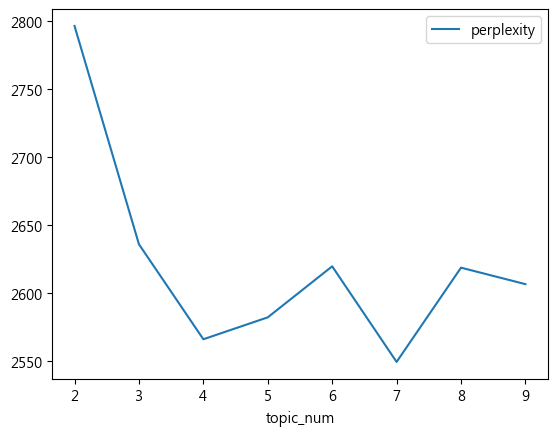

In [41]:
result.plot.line(x='topic_num', y='perplexity')

<AxesSubplot:xlabel='topic_num'>

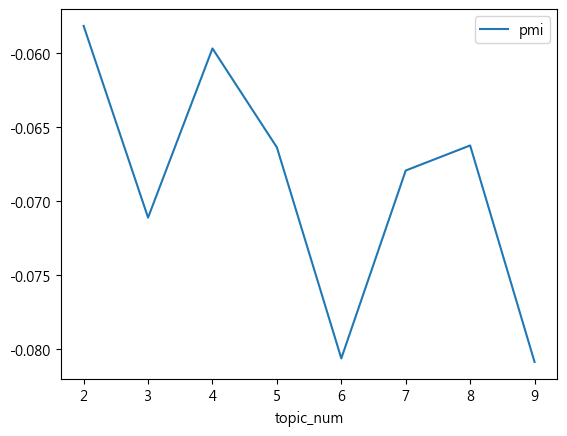

In [42]:
result.plot.line(x='topic_num', y='pmi')

## 5. 視覺化呈現

**5.1 產生 LDAvis 結果**

LDAvis 是我們經常會使用的視覺化工具，目的為幫助我們解釋主題模型中，在我們建構好主題模型得到 θ(文件的主題分佈) 跟 φ(主題的字分佈)，透過 pyLDAvis 將主題降維成二維，以網頁的形式供我們查看。

+ 圓圈數量代表主題數量，有幾個主題就會有幾個圓圈
+ 圓越大代表 document 越大
+ 右邊可以看到主題的字分佈
+ 右上幫有一個 bar 調整 lambda：當 lambda=1 也就是代表本來的字分佈 φ，將 lambda 縮越小可以看到越唯一的字，好的分佈是 φ 高且唯一，因此我們要在這兩者間取平衡
+ 圓心越相近，代表主題會越相似；反之，圓心分越開代表主題有唯一性<br>
  --> 假設詞彙本來有 100 字，維度應該是 100，假如本來維度接近(相近)的話，降維後也會接近(相近)

以下用主題數 4 來做 LDAvis 的結果範例

In [43]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 4,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )

2024-05-06 16:50:25,343 : INFO : using symmetric alpha at 0.25
2024-05-06 16:50:25,343 : INFO : using symmetric eta at 0.25
2024-05-06 16:50:25,345 : INFO : using serial LDA version on this node
2024-05-06 16:50:25,346 : INFO : running online (multi-pass) LDA training, 4 topics, 5 passes over the supplied corpus of 1134 documents, updating model once every 1134 documents, evaluating perplexity every 1134 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-06 16:50:25,348 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-05-06 16:50:26,072 : INFO : -9.186 per-word bound, 582.5 perplexity estimate based on a held-out corpus of 1134 documents with 140464 words
2024-05-06 16:50:26,073 : INFO : PROGRESS: pass 0, at document #1134/1134
2024-05-06 16:50:26,546 : INFO : topic #0 (0.250): 0.014*"黃子佼" + 0.004*"表示" + 0.004*"台灣" + 0.004*"發生" + 0.004*"地震" + 0.004*"報導" + 0.004*"中國" + 0.004*"

In [44]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

C:\Users\giyak\AppData\Roaming\Python\Python37\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.085914 -0.068174       1        1  39.874443
3      0.033040  0.088806       2        1  23.410203
0     -0.087858 -0.040192       3        1  19.289459
1     -0.031096  0.019560       4        1  17.425894, topic_info=     Term        Freq       Total Category  logprob  loglift
2299  黃子佼  903.000000  903.000000  Default  30.0000  30.0000
4884   伊朗  265.000000  265.000000  Default  29.0000  29.0000
4486  以色列  279.000000  279.000000  Default  28.0000  28.0000
48     台灣  768.000000  768.000000  Default  27.0000  27.0000
2261  未成年  257.000000  257.000000  Default  26.0000  26.0000
...   ...         ...         ...      ...      ...      ...
277    希望   60.386768  346.216346   Topic4  -6.0047   0.0009
186    網友   62.451124  508.649023   Topic4  -5.9711  -0.3502
3766   總統   58.150159  259.058156   Topic4  -6.0425   0.2532
48     台灣   61.685974  768.685574   Topic4  -5.9834  -0.7754
2299  黃子佼   62.154616  903.198264   Topic4  -5.9759  -0.9291

[325 rows x 6 columns], token_table=      Topic      Freq Term
term                      
440       1  0.686433   一名
440       2  0.123404   一名
440       3  0.131116   一名
440       4  0.061702   一名
4663      1  0.045686   一平
...     ...       ...  ...
4321      4  0.051530   黃金
5057      1  0.034657  龍捲風
5057      2  0.935731  龍捲風
5057      3  0.034657  龍捲風
5057      4  0.034657  龍捲風

[876 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 2])

In [45]:
pyLDAvis.save_html(p, "lda_ebc_202404.html")

## 6. GuidedLDA

- 原始套件: <https://github.com/vi3k6i5/GuidedLDA>  
- 31lab 家銘修改版本: <https://github.com/Text-Analytics-and-Retrieval/GuidedLDA>

安裝方式:  
`pip install git+https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git#egg=GuidedLDA`  
經測試，在 `python3.7~3.8` 可正常執行

In [46]:
import guidedlda

In [47]:
vocab = tuple(dictionary.token2id.keys())
vocab[:10]

('一定', '一度', '一步', '一起', '下去', '不到', '不好', '不用', '中時', '之外')

In [48]:
word2id = dictionary.token2id

In [54]:
seed_topic_list = [
    ["大谷", "賽事", "聯盟", "先發", "道奇", "奧運"],
    ["演藝圈", "藝人", "音樂", "戲劇", "通告", "表演", "主持人"],
    ["中國", "兩岸", "習近平", "政府", "外交", "立委", "國民黨", "民進黨"],
    ["全球", "美國", "國際", "世界", "日本", "航班"]
]

In [55]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [56]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [58]:
# 多一個主題是for其他
model = guidedlda.GuidedLDA(n_topics=5, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2024-05-06 16:57:32,023 : INFO : n_documents: 1134
2024-05-06 16:57:32,024 : INFO : vocab_size: 5409
2024-05-06 16:57:32,025 : INFO : n_words: 140464
2024-05-06 16:57:32,025 : INFO : n_topics: 5
2024-05-06 16:57:32,026 : INFO : n_iter: 100
2024-05-06 16:57:32,367 : INFO : <0> log likelihood: -1450708
2024-05-06 16:57:32,513 : INFO : <20> log likelihood: -1153534
2024-05-06 16:57:32,658 : INFO : <40> log likelihood: -1138773
2024-05-06 16:57:32,803 : INFO : <60> log likelihood: -1132764
2024-05-06 16:57:32,948 : INFO : <80> log likelihood: -1129885
2024-05-06 16:57:33,087 : INFO : <99> log likelihood: -1128206


In [59]:
# 整理／顯示主題模型結果
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 台灣 大谷 粉絲 今天 直播 奧運 比賽 日本 美國 台北
Topic 1: 黃子佼 表示 影片 未成年 藝人 網友 發文 真的 知道 統神
Topic 2: 立委 徐巧 總統 民進黨 國民黨 市長 議員 大姑 主委 賴清德
Topic 3: 美國 台灣 發生 地震 日本 以色列 表示 中國 伊朗 民眾
Topic 4: 表示 報導 網友 看到 發現 希望 已經 許多 透露 一名


C:\Users\giyak\AppData\Roaming\Python\Python37\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.130236  0.217842       1        1  33.887300
1      0.050235  0.108567       2        1  22.622729
3     -0.078393  0.069599       3        1  22.232686
2      0.213142 -0.289950       4        1  11.015418
0     -0.315221 -0.106058       5        1  10.241867, topic_info=     Term         Freq        Total Category  logprob  loglift
2299  黃子佼  1019.000000  1019.000000  Default  30.0000  30.0000
1982   立委   338.000000   338.000000  Default  29.0000  29.0000
3601   徐巧   303.000000   303.000000  Default  28.0000  28.0000
48     台灣   763.000000   763.000000  Default  27.0000  27.0000
190    美國   556.000000   556.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
103    成為    84.721707   182.574042   Topic5  -5.1346   1.5109
426    日本   100.667446   433.118152   Topic5  -4.9622   0.8195
190    美國    99.670837   556.888451   Topic5  -4.9721   0.5582
159    獲得    61.799706   113.735704   Topic5  -5.4501   1.6687
375    最後    61.799706   246.539212   Topic5  -5.4501   0.8951

[301 rows x 6 columns], token_table=      Topic      Freq Term
term                      
440       1  0.769880   一名
440       2  0.166870   一名
440       3  0.064473   一名
3682      5  1.002399   一粒
3         1  0.695560   一起
...     ...       ...  ...
2036      1  1.000622   餐廳
1011      1  0.261473   香港
1011      5  0.740840   香港
5173      4  1.002582  馬英九
2299      2  0.999698  黃子佼

[452 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 3, 1])

In [84]:
seed_topic_list = [
    ["大谷", "職棒", "聯盟", "先發", "道奇"],
    ['太陽', "職籃"],
    ["藝人", "音樂", "主持人", "演員", "社群", "演出", "演藝圈", "演唱會"],
    ["中國", "兩岸", "習近平", "政府", "外交"],
    ["國際","攻擊","航班","戰略"],
]

seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [85]:
model = guidedlda.GuidedLDA(n_topics=6, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2024-05-06 21:36:27,359 : INFO : n_documents: 1134
2024-05-06 21:36:27,360 : INFO : vocab_size: 5409
2024-05-06 21:36:27,361 : INFO : n_words: 140464
2024-05-06 21:36:27,361 : INFO : n_topics: 6
2024-05-06 21:36:27,361 : INFO : n_iter: 100
2024-05-06 21:36:27,667 : INFO : <0> log likelihood: -1494875
2024-05-06 21:36:27,813 : INFO : <20> log likelihood: -1166004
2024-05-06 21:36:27,959 : INFO : <40> log likelihood: -1147697
2024-05-06 21:36:28,104 : INFO : <60> log likelihood: -1139982
2024-05-06 21:36:28,250 : INFO : <80> log likelihood: -1135886
2024-05-06 21:36:28,392 : INFO : <99> log likelihood: -1132788


In [86]:
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 台灣 大谷 吳卓源 粉絲 奧運 比賽 朱軒洋 韓國 東森 日本
Topic 1: 報導 一名 表示 發現 發生 當時 警方 公司 大陸 男子
Topic 2: 黃子佼 影片 未成年 藝人 表示 網友 統神 少女 小姐 演藝圈
Topic 3: 台灣 中國 總統 立委 美國 主委 民進黨 賴清德 政府 部長
Topic 4: 美國 地震 以色列 伊朗 日本 發生 表示 民眾 台灣 攻擊
Topic 5: 徐巧 真的 網友 表示 希望 看到 覺得 許多 兩人 現在


C:\Users\giyak\AppData\Roaming\Python\Python37\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.033579 -0.189455       1        1  26.621270
1     -0.195088  0.201606       2        1  18.961226
2     -0.222440 -0.133421       3        1  17.353137
4      0.090081  0.234008       4        1  13.771441
3      0.097503 -0.071802       5        1  13.531514
0      0.263523 -0.040935       6        1   9.761411, topic_info=     Term         Freq        Total Category  logprob  loglift
2299  黃子佼  1018.000000  1018.000000  Default  30.0000  30.0000
4486  以色列   303.000000   303.000000  Default  29.0000  29.0000
190    美國   556.000000   556.000000  Default  28.0000  28.0000
2118   地震   327.000000   327.000000  Default  27.0000  27.0000
48     台灣   762.000000   762.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
446    今天    84.702224   315.251929   Topic6  -5.0868   1.0125
103    成為    71.749290   182.574672   Topic6  -5.2528   1.3928
190    美國    80.716706   556.467231   Topic6  -5.1350   0.3961
82     已經    69.756531   525.794252   Topic6  -5.2810   0.3068
200    表示    65.771013  1076.592002   Topic6  -5.3398  -0.4686

[380 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
1135      1  0.986056    一位
1135      6  0.014717    一位
440       1  0.003795    一名
440       2  0.922197    一名
440       3  0.072106    一名
...     ...       ...   ...
4881      4  1.002141    飛彈
2036      1  1.000792    餐廳
239       2  1.000299  馬來西亞
5173      5  1.002039   馬英九
2299      3  1.000160   黃子佼

[593 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 3, 5, 4, 1])

In [61]:
# udn.loc[udn['artCatagory']=='兩岸', "content"].to_csv("tmp.csv")
udn.loc[udn['artCatagory']=='兩岸', "words"].to_csv("words.csv")
udn.loc[udn['artCatagory']=='股市', "words"].to_csv("words_stock.csv")


In [62]:
udn.loc[udn['artCatagory']=='兩岸', "words"].explode().value_counts().to_csv("words_count.csv")
udn.loc[udn['artCatagory']=='股市', "words"].explode().value_counts().to_csv("words_count_stock.csv")

## 7. 主題分佈的應用，搭配其他文章資訊

In [88]:
# 取得每條新聞的主題分佈
topics_doc = best_model.get_document_topics(corpus)

In [92]:
topics_doc[100]

[(0, 0.9969493)]

透過corpus2csc拿到整份文件的theta(主題分布)

In [93]:
m_theta = corpus2csc(topics_doc).T.toarray()
m_theta

array([[0.        , 0.        , 0.99731952, 0.        ],
       [0.12354392, 0.0522551 , 0.80670851, 0.0174925 ],
       [0.03897541, 0.09368271, 0.        , 0.86534852],
       ...,
       [0.52575082, 0.20815775, 0.        , 0.26429233],
       [0.45654896, 0.265356  , 0.        , 0.27584052],
       [0.        , 0.56802833, 0.26633996, 0.16227266]])

取最高機率值，視為是該份文件的主題，當作是他的topic_label

In [94]:
udn['topic_label'] = m_theta.argmax(axis=1) + 1

In [95]:
udn['topic_label'].value_counts()

3    498
4    274
2    185
1    177
Name: topic_label, dtype: int64

In [96]:
udn.head()

,content,artUrl,artCatagory,artDate,words,topic_label
0,我曾經每個月只有賺千元奇軒本名吳奇軒從武打演員到月收入萬不靠著腥羶色炒話題更成為台灣首位千萬...,https://news.ebc.net.tw/news/article/412111,娛樂,2024-04-16 10:11:00,"[曾經, 每個, 千元, 奇軒, 本名, 吳奇軒, 武打, 演員, 收入, 不靠, 腥羶, ...",3
1,南韓女星韓韶禧在被拍到與柳俊烈共同到夏威夷旅遊後火速認愛不過男方前女友惠利的一句真有趣卻意外...,https://news.ebc.net.tw/news/article/412908,娛樂,2024-04-01 07:59:00,"[韓女星, 韓韶禧, 柳俊烈, 共同, 夏威夷, 旅遊, 火速, 認愛, 男方, 前女友, ...",3
2,知名主播李天怡受三立老闆張榮華委託替頑皮世界動物園赴非洲購買野生動物卻浮報價格上億元涉背信罪...,https://news.ebc.net.tw/news/article/412918,娛樂,2024-04-01 08:20:00,"[知名, 主播, 李天怡, 受三立, 老闆, 榮華, 委託, 頑皮, 世界, 動物園, 非洲...",4
3,在大稻埕的預約制咖啡廳品嘗冰拿鐵知名日本藝術家村上隆引起現場一陣歡笑聲他表示好久沒有來台灣放...,https://news.ebc.net.tw/news/article/412950,娛樂,2024-04-01 10:43:00,"[大稻, 預約, 咖啡廳, 品嘗冰, 知名, 日本, 藝術家, 村上, 引起, 現場, 一陣...",3
4,韓國人氣女團日前傳出在台灣進行秘密拍攝行程遭附近網友目擊後消息隨即在網路上傳開甚至連五月天阿...,https://news.ebc.net.tw/news/article/412951,娛樂,2024-04-01 10:51:00,"[韓國, 人氣, 女團, 日前, 傳出, 台灣, 進行, 秘密, 拍攝, 行程, 附近, 網...",3


In [97]:
udn['artDate'] = pd.to_datetime(udn['artDate'])


In [98]:
udn['artDate'].dt.date

0       2024-04-16
1       2024-04-01
2       2024-04-01
3       2024-04-01
4       2024-04-01
           ...    
1129    2024-04-25
1130    2024-04-25
1131    2024-04-25
1132    2024-04-25
1133    2024-04-25
Name: artDate, Length: 1134, dtype: object

In [99]:
udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True)

artDate     topic_label
2024-04-01  3              0.648148
            4              0.277778
            1              0.055556
            2              0.018519
2024-04-02  3              0.673913
                             ...   
2024-04-24  2              0.080000
2024-04-25  3              0.560976
            4              0.243902
            2              0.121951
            1              0.073171
Name: topic_label, Length: 97, dtype: float64

In [100]:
date_topic = udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

topic_label,1,2,3,4
artDate,,,,
2024-04-01,0.055556,0.018519,0.648148,0.277778
2024-04-02,0.043478,0.086957,0.673913,0.195652
2024-04-03,0.117647,0.058824,0.235294,0.588235
2024-04-04,0.250000,0.062500,0.343750,0.343750
2024-04-05,0.200000,0.080000,0.400000,0.320000


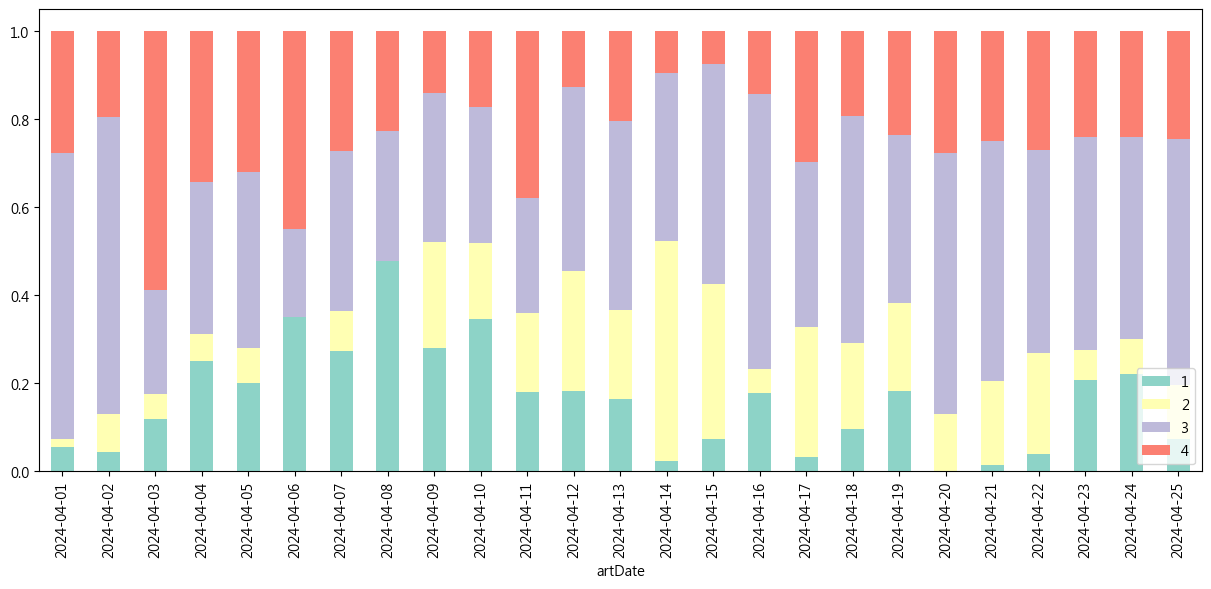

In [101]:
fig, ax = plt.subplots(figsize=(15, 6))
date_topic.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)
ax.legend(loc='lower right')

可以看到主題3（中國各產業市場）在 2/15、2/16 被討論的比例很高，可以作為後續探索的目標，<br>
大家可以像這樣，透過搭配文章的資訊（例如日期等），讓主題模型的結果做出更多的分析應用。